## <font color='limegreen'>HIRING DEMAND FORECASTING</font>
### <font color='limegreen'>I - DATA ANALYSIS</font>

Data Source: Synthetic data created exclusively for this project.

In [29]:
# Python Language Version
from platform import python_version
print('The python version used in this jupyter notebook:', python_version())

The python version used in this jupyter notebook: 3.13.5


In [30]:
# Jupyter execution path
#import sys
#print(sys.executable)

### 1. LOAD PACKAGES

#### Import packages

In [31]:
%%capture output
!pip install -q -r requirements.txt

#### Import functions

In [32]:
from utils import *

In [33]:
from utils import normality_shapiro, identify_nulls, analyze_trend, bds_test_acf, evaluate_skewness, breusch_pagan_test, test_ljung_box

In [34]:
# Record package versions
# !pip install -q -U watermark

In [35]:
# Packages versions
%reload_ext watermark
%watermark --iversions

seaborn      : 0.13.2
joblib       : 1.4.2
numpy        : 2.1.3
sklearn      : 1.6.1
plotly       : 5.24.1
keras        : 3.12.0.dev2025092403
torchvision  : 0.25.0.dev20250923+cpu
pandas       : 2.2.3
psycopg2     : 2.9.10 (dt dec pq3 ext lo64)
platform     : 1.0.8
matplotlib   : 3.10.0
tensorflow   : 2.21.0-dev20250922
torchaudio   : 2.8.0.dev20250923+cpu
pymannkendall: 1.4.3
scipy        : 1.15.3
torch        : 2.10.0.dev20250923+cpu
sys          : 3.13.5 | packaged by Anaconda, Inc. | (main, Jun 12 2025, 16:37:03) [MSC v.1929 64 bit (AMD64)]
statsmodels  : 0.14.4



### 2. LOAD DATA

In [36]:
# Load original
df_origin = pd.read_csv('../data/contratacoes_raw_data.csv')

In [37]:
# Original data copy
df = df_origin.copy()

### 3. UNDERSTANDE AND PROCESS DATA

In [38]:
df.head()

,data,contratacoes
0,2020-01-01,241.0
1,2020-01-02,175.0
2,2020-01-03,235.0
3,2020-01-04,117.0
4,2020-01-05,124.0


In [39]:
df.tail()

,data,contratacoes
1881,2025-02-24,260.0
1882,2025-02-25,197.0
1883,2025-02-26,231.0
1884,2025-02-27,NaN
1885,2025-02-28,214.0


In [40]:
df.shape

(1886, 2)

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1886 entries, 0 to 1885
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   data          1886 non-null   object 
 1   contratacoes  1708 non-null   float64
dtypes: float64(1), object(1)
memory usage: 29.6+ KB


In [42]:
df.columns

Index(['data', 'contratacoes'], dtype='object')

In [43]:
# Dicitionary of variables
dic01 = {
    "data": "Data da contratacao.",
    "total_contratacoes": "Número de empréstimos pessoais efetivados.",}

In [44]:
# Time series period
print(f"Time series period: {df['data'].min()} to {df['data'].max()}")

Time series period: 2020-01-01 to 2025-02-28


In [45]:
# Convert 'data' variable to datetime and index
df['data'] = pd.to_datetime(df['data'], format='%Y-%m-%d')
df = df.set_index('data').asfreq('D')

In [46]:
# Total null values
df.isnull().sum().sum()

np.int64(178)

In [47]:
# Percentage of null values
(df.isnull().mean() * 100).round(2)

contratacoes    9.44
dtype: float64

### 4. EXPLORATORY ANALYSIS

In [48]:
# View time series
fig1 = px.line(df, x=df.index, y='contratacoes', title='Série Temporal', 
               width=1000, height=400)
fig1.show()

`Análise Técnica` 

A série apresenta indícios de sazonalidade mensal e tendência crescente, tornando essencial uma análise mais detalhada para identificar padrões recorrentes ao longo do tempo.

In [49]:
# Distribution of the variable
fig2 = px.histogram(df, x='contratacoes', nbins=30, 
                   title='Distribuição da Variável', 
                   labels={'contratacoes'}, 
                   width=800, height=400)
fig2.show()

`Análise Técnica`

Apesar da presença de valores nulos, a análise da distribuição é fundamental para identificar a assimetria da variável, fornecendo insights valiosos para orientar a escolha do tratamento mais adequado tanto para os valores nulos quanto para possíveis outliers. Nesse contexto, observa-se uma cauda alongada à direita, caracterizando uma assimetria positiva, na qual a média é significativamente maior que a mediana. Essa característica sugere a presença de valores extremos ou outliers que influenciam a média, reforçando a importância de adotar estratégias robustas, como o uso da mediana ou transformações nos dados, para garantir a precisão das análises.

In [50]:
df.describe()

,contratacoes
count,1708.000000
mean,172.727752
std,66.228247
min,39.000000
25%,124.000000
50%,163.000000
75%,213.000000
max,491.000000


In [51]:
# Function to check normality
normality_shapiro(df, 'contratacoes')

Shapiro-Wilk Test: Statistic=nan, p=nan
Non-normal distribution


np.float64(nan)

`Análise Técnica`
- A saída 'nan' indique que a função detectou que não conseguiu calcular o teste corretamente.

O p-valor é nan geralmente acontece quando há:
- Muitos valores ausentes na variável.
- Poucos dados válidos para o teste estatístico (normalmente precisa de pelo menos 8 pontos de dados).
- Valores constantes (sem variação), o que impossibilita o cálculo das estatísticas.

#### 4.1. CHECK OUTLIERS

In [52]:
# Boxplot outliers values
fig3 = px.box(df, y='contratacoes', title='Boxplot', 
              labels={'contratacoes'}, width=500, height=400)
fig3.show()

In [53]:
# Calculate the IQR 
Q1 = df[['contratacoes']].quantile(0.25)
Q3 = df[['contratacoes']].quantile(0.75)
IQR = Q3 - Q1

In [54]:
# Limits of the variable
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [55]:
# Identify outliers 
outliers = (df['contratacoes'] < lower_bound['contratacoes']) | (df['contratacoes'] > upper_bound['contratacoes'])

In [56]:
# Total outliers
outliers_count = outliers.sum()
print(f"Number of outliers: {outliers_count}")

Number of outliers: 22


In [57]:
# DataFrame with only outliers
df_outliers = df[outliers]

In [58]:
df_outliers.head()

,contratacoes
data,
2020-02-04,375.0
2020-06-04,380.0
2020-11-03,425.0
2021-01-01,369.0
2021-02-02,415.0


#### 4.2. NULL VALUE HANDLING

In [59]:
# Null values
df.isnull().sum()

contratacoes    178
dtype: int64

In [60]:
# Estatistics numerical variables
df.describe()

,contratacoes
count,1708.000000
mean,172.727752
std,66.228247
min,39.000000
25%,124.000000
50%,163.000000
75%,213.000000
max,491.000000


In [61]:
# Function to identifies null values
df_copy, count = identify_nulls(df, 'contratacoes')
print(count)

Total isolated nulls: 144
Total consecutive nulls (2-7 days): 34
Total long nulls (>7 days): 0


`Decisão Técnica`

Vamos utlizar a Interpolação Temporal para preencher os nulos isolados e a Média Móvel Ajustada para suavizar os nulos consecutivos, mantendo a tendência e sazonalidade dos dados.

In [62]:
# Temporal interpolation for isolated nulls
df_copy.loc[df_copy['isolated_null'], 'contratacoes'] = df_copy['contratacoes'].interpolate(method='time')

`Justificativa Técnica`

O uso da **Interpolação Temporal** preserva padrões sazonais, sem criar tendências artificiais e mantém a continuidade da série sem alterar a tendência.

In [63]:
# Check for nulls after interpolation
print(df_copy.isnull().sum())

contratacoes        34
isolated_null        0
consecutive_null     0
long_null            0
dtype: int64


In [64]:
# Adjusted Moving Average for short blocks
df_copy.loc[df_copy['consecutive_null'], 'contratacoes'] = df_copy['contratacoes'].fillna(
    df_copy['contratacoes'].rolling(window=7, min_periods=1, center=True).mean())

`Justificativa Técnica`

O uso da **Média Móvel Ajustada** reduz o impacto de outliers, suaviza variações sem perder a sequência da série e funciona bem para períodos curtos de dados ausentes.

In [65]:
# Check the nulls after interpolation
print(df_copy.isnull().sum())

contratacoes        0
isolated_null       0
consecutive_null    0
long_null           0
dtype: int64


In [66]:
# Delete variables created for identify null values
df_copy.drop(columns=['isolated_null', 'consecutive_null', 'long_null'], inplace=True)

In [67]:
df_copy.head()

,contratacoes
data,
2020-01-01,241.0
2020-01-02,175.0
2020-01-03,235.0
2020-01-04,117.0
2020-01-05,124.0


In [68]:
# Descriptive Statistic
df_copy.describe()

,contratacoes
count,1886.000000
mean,173.222318
std,64.972734
min,39.000000
25%,126.000000
50%,163.500000
75%,213.000000
max,491.000000


`Análise Técnica`

Os valores estão em uma faixa moderada, variando entre 39 e 491, indicando uma discrepância de escala gerenciável.

### 5. TIME SERIES ANALYSIS - I

#### 5.1. DATA DISTRIBUTION

In [69]:
# Distribution of the variable 
fig4 = px.histogram(df_copy, x='contratacoes', nbins=30, 
                   title='Distribution of the Variable', 
                   labels={'contratacoes'}, 
                   width=800, height=400)
fig4.show()

In [70]:
# Functions to check Normality
normality_shapiro(df_copy, 'contratacoes')

Shapiro-Wilk Test: Statistic=0.966, p=0.000
Non-normal distribution


np.float64(1.322078824207138e-20)

#### 5.2. SERIES VIEW

In [71]:
# View Series
fig5 = px.line(df_copy, x=df_copy.index, y='contratacoes', title='TIME SERIES', 
               width=1000, height=400)
fig5.update_layout(xaxis_title='data')
fig5.show()

#### 5.3. FIRST TREND ANALYSIS 

In [72]:
# Function to check trend (Test Mann-Kendall)
analyze_trend(df_copy['contratacoes'])

Identified Trend: Increasing
p-value: 0.0
Statistical Significance: Significant


#### 5.4. SECOND TREND ANALYSIS

In [73]:
# Time series Boxplot
fig6 = px.box(df_copy, x=df_copy.index.year, y="contratacoes", 
             title="Boxplot",
             labels={"contratacoes": "contratacoes", "x": "Year"},
             template="plotly_white", width=800, height=400)
fig6.show()

`Análise Técnica`

- Presença de outliers já identificada na série.
- O aumento da mediana ao longo dos anos confirma uma tendência ascendente.
- As caixas possuem tamanhos diferentes indicando uma dispersão da variável em torno da mediana.
- Um modelo considerando a sazonalidade pode funcionar bem para prever esta série.

#### 5.5. CHECK STATIONARITY

**Teste de Dickey-Fuller**

In [74]:
# Function to check stationarity
test_dickey_fuller(df_copy['contratacoes'])

ADF Statistic: -4.145218075712447
p-value: 0.0008146258618862328
The series is stationary


In [ ]:
# Save clean file
file_path = os.path.join('..', 'data', 'contratacoes_clean_data.csv')
df_copy.to_csv(file_path, index=True)
print(f"File saved successfully at: {file_path}, including the index!")

File saved successfully at: ..\data\clean_data.csv, including the index!


### 5.6. RESPONDENDO PERGUNTAS DE NEGÓCIO

In [76]:
# 1. Como as contratações variam ao longo dos meses?
df_copy['month'] = df_copy.index.month
monthly_avg = df_copy.groupby('month')['contratacoes'].mean().reset_index()

fig7 = px.bar(monthly_avg, x='month', y='contratacoes', 
              labels={'month': 'Mês', 'contratacoes': 'Contratações'},
              title='Média mensal de contratações (2020-2025)', 
              color='month', color_discrete_sequence=px.colors.qualitative.Set1, 
              width=800, height=400)
fig7.show()

In [77]:
# 2. Em que período do mês há maior volume de contratações? 
# Existem padrões intra-mensais que impactam a demanda?
df_copy['day'] = df_copy.index.day
daily_avg = df_copy.groupby('day')['contratacoes'].mean().reset_index()

fig8 = px.line(daily_avg, x='day', y='contratacoes', 
               labels={'day': 'Dia do Mês', 'contratacoes': 'Contratações'},
               title='Média diária de contratações por dia do mês (2020-2025)', markers=True,
               width=900, height=300)
fig8.show()

`Análise Técnica`

O período entre os dias 1º e 10 do mês concentra o maior volume de contratações.

In [78]:
# 3. Quais são os períodos de menor demanda que representam oportunidades para investimentos em campanhas de marketing?

# Identificar os dias com menor demanda (menores 25%)
lower_demand_days = df_copy[df_copy['contratacoes'] <= df_copy['contratacoes'].quantile(0.25)].copy() # Use .copy() para evitar SettingWithCopyWarning

# Agrupar os dias de baixa demanda por mês
lower_demand_days['month'] = lower_demand_days.index.month
demand_by_month = lower_demand_days.groupby('month')['contratacoes'].count().reset_index()

# Plotar
fig9 = px.bar(demand_by_month, x='month', y='contratacoes',
                 labels={'month': 'Mês', 'contratacoes': 'Quantidade de dias de baixa demanda'},
                 title='Número de dias de baixa demanda por mês (2020-2025)', color='month',
                 color_discrete_sequence=px.colors.qualitative.Set1)
fig9.show()

`Análise Técnica`

Os meses de dezembro, setembro, agosto, novembro e junho apresentam a menor demanda, destacando-se como oportunidades para investimentos em campanhas de marketing.

In [79]:
# 4. Como as contratações evoluíram ao longo do tempo? A demanda está em crescimento, queda ou estabilidade?

# Média móvel de 30 dias
df_copy['rolling_mean'] = df_copy['contratacoes'].rolling(window=30).mean()

# Gráfico de linhas
fig10 = px.line(df_copy, x=df_copy.index, y=['contratacoes', 'rolling_mean'],
              labels={'value': 'Contratações', 'variable': 'Legenda'},
              title='Tendência Geral de Contratações (2020-2025)')

# Atualizar nomes das linhas
fig10.for_each_trace(lambda t: t.update(name='Média Móvel (30 dias)' if t.name == 'rolling_mean' else 'Contratações'))

# Ajustar tamanho
fig10.update_layout(width=1000, height=400)

fig10.show()

`Análise Técnica`

A demanda apresenta uma sazonalidade mensal e uma  tendência consistente de crescimento ao longo dos anos, indicando um movimento positivo e sustentável.

In [80]:
# 5. Há mais contratações nos dias de semana ou nos finais de semana?
import plotly.graph_objects as go

# Adicionar coluna com o dia da semana (0 = segunda, 6 = domingo)
df_copy['weekday'] = df_copy.index.dayofweek

# Calcular médias
day_avg = df_copy.loc[df_copy['weekday'] < 5, 'contratacoes'].mean()
weekend_avg = df_copy.loc[df_copy['weekday'] >= 5, 'contratacoes'].mean()

# Criar gráfico com cores nomeadas
fig11 = go.Figure(data=[
    go.Bar(x=['Dias Úteis', 'Finais de Semana'], y=[day_avg, weekend_avg],
           marker_color=['RoyalBlue', 'DarkOrange'])])

# Layout
fig11.update_layout(
    title='Média de Contratações: Dias Úteis vs Finais de Semana',
    yaxis_title='Contratações',
    xaxis_title='Tipo de Dia',
    width=800, height=400)

fig11.show()

`Análise Técnica`

A análise revelou que, de forma consistente, os dias da semana registram uma demanda significativamente maior por contratações em comparação aos finais de semana.

In [81]:
df_copy.head()

,contratacoes,month,day,rolling_mean,weekday
data,,,,,
2020-01-01,241.0,1,1,NaN,2
2020-01-02,175.0,1,2,NaN,3
2020-01-03,235.0,1,3,NaN,4
2020-01-04,117.0,1,4,NaN,5
2020-01-05,124.0,1,5,NaN,6


In [82]:
# Drop created variables that are not useful for the model
df_copy = df_copy.drop(columns=['month', 'day', 'rolling_mean', 'weekday'])

In [83]:
df_copy.head()

,contratacoes
data,
2020-01-01,241.0
2020-01-02,175.0
2020-01-03,235.0
2020-01-04,117.0
2020-01-05,124.0


### 6. ANALYSIS FOR LOGARITHMIC TRANSFORMATION
A checagem de necessidade da transformação logarítmica deve ocorrer antes de qualquer modelagem da série, pois decomposições (aditiva ou multiplicativa) e antes de testes de estacionaridade que podem ser afetados por variações não estabilizadas, resultando em conclusões equivocadas sobre tendências e sazonalidade. 

In [84]:
# Apply Box-Cox to obtain the lambda value
_, lambda_value = boxcox(df_copy['contratacoes'])

# Determine the series behavior based on the lambda value
if abs(lambda_value) < 0.1:  # Multiplicative behavior
    print(f"Ideal lambda: {lambda_value}. The series has MULTIPLICATIVE behavior.")
elif abs(lambda_value - 1) < 0.1:  # Additive behavior
    print(f"Ideal lambda: {lambda_value}. The series has ADDITIVE behavior.")
else:  # Intermediate behavior
    print(f"Ideal lambda: {lambda_value}. The series has INTERMEDIATE behavior.")

Ideal lambda: 0.2540838929398412. The series has INTERMEDIATE behavior.


ADF Test - p-value: 0.0008146258618862328
ADF Test - ADF Statistic: -4.145218075712447


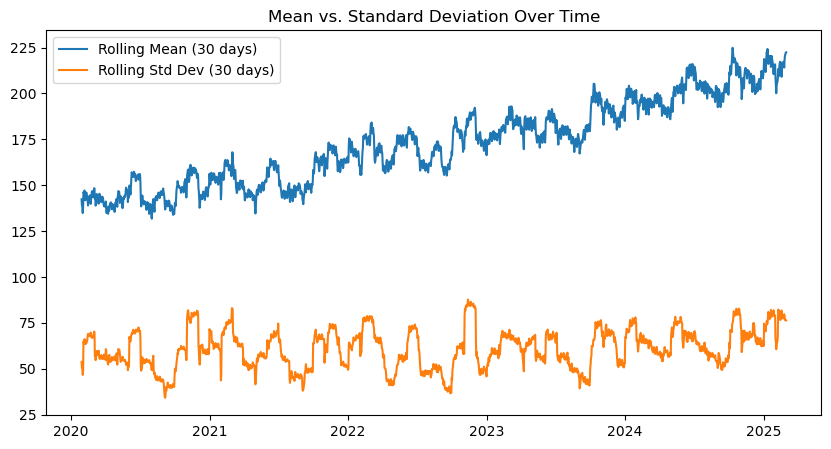

✅ Logarithmic transformation not necessary.


{'heteroscedasticity_p_value': np.float64(0.05537528781405025),
 'skewness': np.float64(0.7602983888797283),
 'adf_p_value': np.float64(0.0008146258618862328),
 'adf_statistic': np.float64(-4.145218075712447),
 'log_recommended': np.False_}

In [85]:
# Function to check log transformation
log_transformation(df_copy, 'contratacoes')

`Análise Técnica`

Como a série é estacionária, não há necessidade de decomposição temporal. Além disso, a transformação logarítmica não se faz necessária. Portanto, podemos prosseguir com a análise da série.

### 7. TIME SERIES ANALYSIS - II

##### 7.1. CHECK LINEARITY

In [86]:
# Function to check linearity (Test BDS)
result = bds_test_acf(df_copy['contratacoes'].dropna())
print(result)

Non-linear patterns detected


##### 7.2. VCHECK SYMMETRY

In [87]:
# Function to check skewness
result = evaluate_skewness(df_copy, column='contratacoes') 
print(f"Skewness: {result['skewness']:.4f}")
print(f"Interpretation: {result['interpretation']}")

Skewness: 0.7603
Interpretation: The distribution is right-skewed (long tail to the right).


##### 7.3. HETEROSCEDASTICITY
O teste de Breusch-Pagan é um teste estatístico usado para verificar a presença de heterocedasticidade em um modelo de regressão. A heterocedasticidade ocorre quando a variância dos erros (resíduos) de um modelo não é constante ao longo dos valores das variáveis independentes, o que viola uma das premissas básicas dos modelos de regressão linear (homocedasticidade).

In [88]:
# Function to check heteroscedasticity
result = breusch_pagan_test(df_copy, 'contratacoes')
print("P-value:", result['p_value'])
print("Interpretation:", result['interpretation'])

P-value: 0.05537528781405025
Interpretation: Heteroscedasticity not detected (null hypothesis of homoscedasticity not rejected).


##### 7.4. AUTOCORRELATION

O teste de Ljung-Box verifica se há autocorrelação nos resíduos de um modelo de série temporal, ajudando a identificar se o modelo captura adequadamente as dependências temporais. Caso a hipótese de independência seja rejeitada, sugere-se a utilização de modelos estatísticos ou algoritmos de machine learning para melhorar a previsão.

In [89]:
# Function to check autocorrelation (Ljung-Box Test)
message, numerical_result = test_ljung_box(df_copy['contratacoes'].dropna())
print(numerical_result)
print(message)

          lb_stat  lb_pvalue
365  35267.338829        0.0
Evidence of autocorrelation found (p-value = 0.0000).


In [90]:
df_copy.head()

,contratacoes
data,
2020-01-01,241.0
2020-01-02,175.0
2020-01-03,235.0
2020-01-04,117.0
2020-01-05,124.0


In [91]:
df_copy.shape

(1886, 1)

In [92]:
df_copy.describe()

,contratacoes
count,1886.000000
mean,173.222318
std,64.972734
min,39.000000
25%,126.000000
50%,163.500000
75%,213.000000
max,491.000000


`Resumo Técnico`

A série temporal univariada abrange o período de 01/01/2020 a 28/02/2025, totalizando 1.886 registros. O conjunto de dados contém as variáveis 'data' (índice datetime) e 'contratacoes'. A série apresenta uma distribuição não normal, com assimetria à direita, padrões não lineares, e a presença de outliers. Apesar dessas características, a série é estacionária, homocedástica, exibindo sazonalidade, uma tendência de crescimento e correlação significativa.

`Decisão Técnica`

Com base nas características identificadas, a modelagem estatística será conduzida utilizando algoritmos cujos pressupostos estejam alinhados aos padrões observados. O objetivo é gerar previsões para os próximos seis meses, considerando a estrutura da série temporal e suas dinâmicas específicas.

#### POTENTIAL MODELS

Com base nas características da série temporal (não linearidade, sazonalidade, homocedasticidade e outliers), os modelos indicados seriam:

Modelagem Estística:
- SARIMA: Indicado pela presença de sazonalidade e tendência, sendo capaz de capturar padrões autorregressivos, médias móveis e componentes sazonais.

Machine Learning/Deep Learning:
- LSTM e/ou GRU: Para capturar dependências temporais e padrões não lineares, especialmente se a série tiver dependências de longo prazo.


### END OF DATA ANALYSIS
Concluímos a análise da série temporal e os dados estão prontos para a Modelagem Estatística e/ou Machine Learning.